In [1]:
#Necessary packages
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from math import sqrt
import datetime 
import calendar
import sys

In [21]:
# Load your data
file_path = r'C:\Users\PHIRI003\OneDrive - Wageningen University & Research\Documents\WEcR Internship\Work\R\Modified_Book1.xlsx'
df = pd.read_excel(file_path, header=0, sheet_name = 'Sheet2')

# Define the start and end dates
#start_date = '2010-01-01'
#end_date = '2023-10-31'

# Filter the DataFrame to include only the desired date range
#df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

df.index = df['Date']

In [22]:
# Define the function for seasonal dummies
def SeasonalDummies(df, frequency='M'): 
    nT = len(df)
    startdate = df.index[0]
    datetime = pd.DataFrame(columns=["datetime"],
                            data=pd.date_range(startdate, periods=nT, freq=frequency))
    monthnumber = datetime["datetime"].dt.month
    monthname = pd.DataFrame()
    for i in range(nT):
        monthname.at[i, 'D'] = calendar.month_name[monthnumber[i]]
    seasdum = pd.get_dummies(monthname)
    seasdum = seasdum.drop('D_January', axis=1)
    seasdum = seasdum.set_index(df.index)
    
    # to ensure all columns in seasdum are numeric
    seasdum = seasdum.astype(int)
    
    return seasdum

# Create seasonal dummies
seasdum = SeasonalDummies(df)

df = pd.concat([df, seasdum], axis=1)


In [25]:
#df.head(5)

In [24]:
import itertools
from itertools import combinations
import statsmodels.api as sm
import pandas as pd
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt


# Define the function to perform the ZA test with seasonal dummies
def zivot_andrews_with_dummies(y, seasdum, max_lag=12, num_breaks=1):
    nT = len(y)
    m = 6  # Minimum distance between breaks
    h = int(nT * 0.15)  # Minimum distance from the start and end (trimming)
    
    best_t_stat = float('inf')
    best_breaks = None
    unit_root_stat = None
    
    # Generate all possible combinations of break points
    potential_breaks = range(h, nT - h) 
    all_combinations = list(combinations(potential_breaks, num_breaks)) 
    
    for breaks in all_combinations:
        if all(abs(breaks[i] - breaks[i-1]) >= m for i in range(1, num_breaks)):
            X = seasdum.copy()
            for i, bp in enumerate(breaks):
                X[f'break_{i}'] = (np.arange(nT) >= bp).astype(int) #dummy for break in intercept
                X[f'break_trend_{i}'] = X[f'break_{i}'] * np.arange(nT) # break in the trend
            X['const'] = 1 #constant
            X['trend'] = np.arange(nT) #trend variable
            
            # Add lagged differences
            for lag in range(1, max_lag + 1):
                X[f'lag_{lag}'] = y.diff(lag).shift(lag)
            
            # Drop rows with NaN values
            X = X.dropna()
            y_valid = y[X.index] #indexed data
            
            # Ensure all columns in X are numeric
            X = X.apply(pd.to_numeric, errors='coerce')
            
            # Fit the model
            model = sm.OLS(y_valid, X).fit() # regression with both break in intercept and break in trend 
            t_stat = min(abs(model.tvalues[f'break_{i}']) for i in range(num_breaks)) #minimum t statistic for the identified trend
            ur_stat = model.tvalues.iloc[1]  # t-statistic for the lagged level term( the paameter of interest)
            
            if abs(t_stat) < abs(best_t_stat): #absolute best t-statistic
                best_t_stat = t_stat
                best_breaks = breaks
                unit_root_stat = ur_stat
                
    return best_breaks, best_t_stat, unit_root_stat

# Perform the Lumsdaine and Papell test on each series and print the results
for column in ['PPI', 'Wheat Price', 'Oil Price', 'CPI', 'Wage']:
    print(f"\nZivot-Andrews test for {column}:")
    break_points, t_stat, unit_root_stat = zivot_andrews_with_dummies(df[column], seasdum)
    
    print("Best break points:", [df.index[bp] for bp in break_points])
    print("T-statistic at best break points:", t_stat)
    print("Unit root test statistic:", unit_root_stat)



Zivot-Andrews test for PPI:
Best break points: [Timestamp('2012-09-01 00:00:00')]
T-statistic at best break points: 0.03813017183174546
Unit root test statistic: -3.8533290005788388

Zivot-Andrews test for Wheat Price:
Best break points: [Timestamp('2012-05-01 00:00:00')]
T-statistic at best break points: 0.012769472598263101
Unit root test statistic: -0.3866086382981031

Zivot-Andrews test for Oil Price:
Best break points: [Timestamp('2012-10-01 00:00:00')]
T-statistic at best break points: 0.006236859595082221
Unit root test statistic: 0.4240216353643487

Zivot-Andrews test for CPI:
Best break points: [Timestamp('2016-07-01 00:00:00')]
T-statistic at best break points: 0.08816805647019095
Unit root test statistic: -1.339802007286487

Zivot-Andrews test for Wage:
Best break points: [Timestamp('2012-03-01 00:00:00')]
T-statistic at best break points: 0.10194932797726373
Unit root test statistic: -2.896037477612991



Analysis for PPI:
Lumsdaine-Papell best break points: [Timestamp('2019-11-01 00:00:00'), Timestamp('2020-07-01 00:00:00')]
T-statistic at best break points: 0.0007686111475045783
Unit root test statistic: -3.888705187439892
Bai-Perron breakpoints: [Timestamp('2012-02-01 00:00:00'), Timestamp('2015-01-01 00:00:00'), Timestamp('2022-02-01 00:00:00'), Timestamp('2022-12-01 00:00:00')]
Similar breaks between methods: []


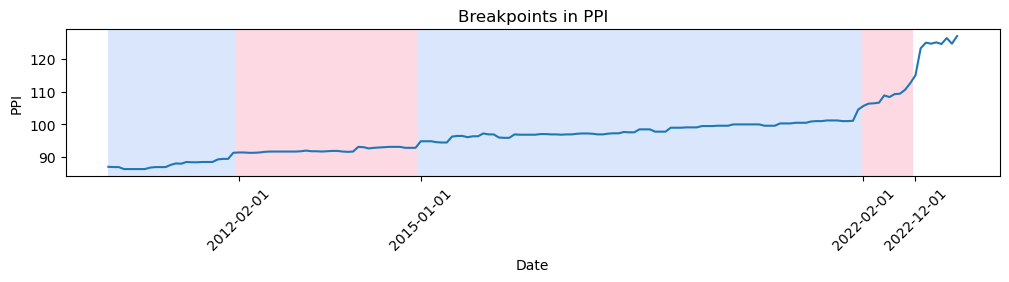


Analysis for CPI:
Lumsdaine-Papell best break points: [Timestamp('2013-02-01 00:00:00'), Timestamp('2013-11-01 00:00:00')]
T-statistic at best break points: 2.888761048336622e-05
Unit root test statistic: -1.3302348752730493
Bai-Perron breakpoints: [Timestamp('2012-02-01 00:00:00'), Timestamp('2019-03-01 00:00:00'), Timestamp('2022-07-01 00:00:00'), Timestamp('2022-12-01 00:00:00')]
Similar breaks between methods: []


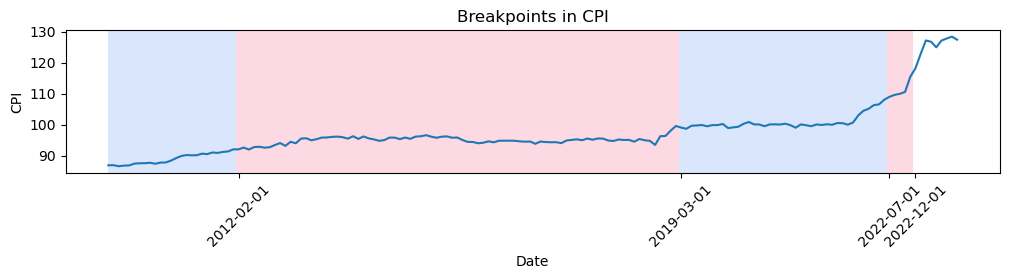


Analysis for Oil Price:
Lumsdaine-Papell best break points: [Timestamp('2013-09-01 00:00:00'), Timestamp('2014-01-01 00:00:00')]
T-statistic at best break points: 0.00016043643615734868
Unit root test statistic: -0.08152300942184834
Bai-Perron breakpoints: [Timestamp('2010-11-01 00:00:00'), Timestamp('2014-08-01 00:00:00'), Timestamp('2015-01-01 00:00:00'), Timestamp('2021-09-01 00:00:00')]
Similar breaks between methods: []


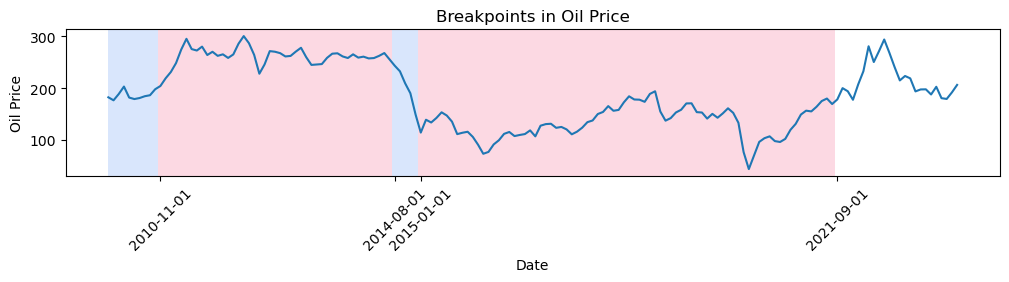


Analysis for Wheat Price:
Lumsdaine-Papell best break points: [Timestamp('2012-04-01 00:00:00'), Timestamp('2016-10-01 00:00:00')]
T-statistic at best break points: 4.732281389440613e-05
Unit root test statistic: -1.0832581886611368
Bai-Perron breakpoints: [Timestamp('2010-11-01 00:00:00'), Timestamp('2015-01-01 00:00:00'), Timestamp('2020-11-01 00:00:00'), Timestamp('2021-09-01 00:00:00')]
Similar breaks between methods: []


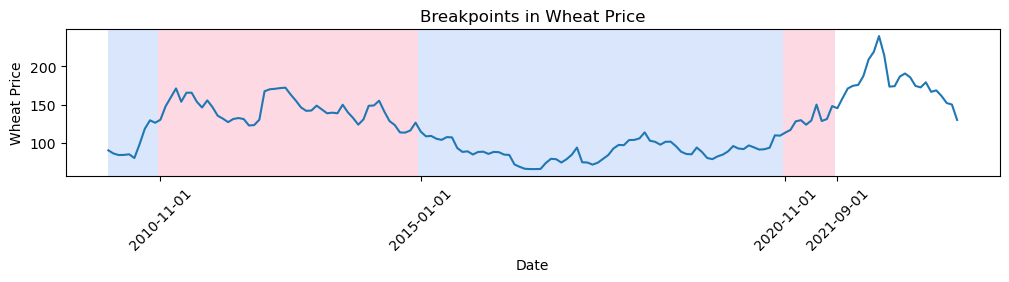


Analysis for Wage:
Lumsdaine-Papell best break points: [Timestamp('2015-05-01 00:00:00'), Timestamp('2016-02-01 00:00:00')]
T-statistic at best break points: 0.00028622326488592526
Unit root test statistic: -3.4906287457911236
Bai-Perron breakpoints: [Timestamp('2014-03-01 00:00:00'), Timestamp('2017-02-01 00:00:00'), Timestamp('2018-10-01 00:00:00'), Timestamp('2022-02-01 00:00:00')]
Similar breaks between methods: []


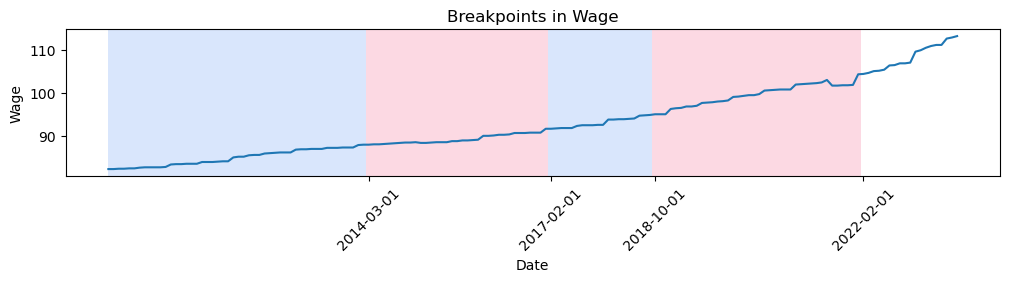

In [30]:
import itertools
from itertools import combinations
import statsmodels.api as sm
import pandas as pd
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt

# Define the function to perform the Lumsdaine and Papell test with seasonal dummies
def lumsdaine_papell_with_seasonal_dummies(y, seasdum, max_lag=12, num_breaks=2):
    nT = len(y)
    m = 4  # Minimum distance between breaks
    h = int(nT * 0.15)  # Minimum distance from the start and end
    
    best_t_stat = float('inf')
    best_breaks = None
    unit_root_stat = None
    
    # Generate all possible combinations of break points
    potential_breaks = range(h, nT - h)
    all_combinations = list(itertools.combinations(potential_breaks, num_breaks))
    
    for breaks in all_combinations:
        if all(abs(breaks[i] - breaks[i-1]) >= m for i in range(1, num_breaks)):
            X = seasdum.copy()
            for i, bp in enumerate(breaks):
                X[f'break_{i}'] = (np.arange(nT) >= bp).astype(int) #break in levels
                X[f'break_trend_{i}'] = X[f'break_{i}'] * np.arange(nT)  #break in trend
            X['const'] = 1 #constant term
            X['trend'] = np.arange(nT)
            
            # Add lagged differences
            for lag in range(1, max_lag + 1):
                X[f'lag_{lag}'] = y.diff(lag).shift(lag)
            
            # Drop rows with NaN values
            X = X.dropna()
            y_valid = y[X.index]
            
            # Ensure all columns in X are numeric
            X = X.apply(pd.to_numeric, errors='coerce')
            
            # Fit the model
            model = sm.OLS(y_valid, X).fit()
            t_stat = min(abs(model.tvalues[f'break_{i}']) for i in range(num_breaks))
            ur_stat = model.tvalues.iloc[1]  # t-statistic for the lagged level term 
            
            if abs(t_stat) < abs(best_t_stat):
                best_t_stat = t_stat
                best_breaks = breaks
                unit_root_stat = ur_stat
                
    return best_breaks, best_t_stat, unit_root_stat

# Function to apply Bai-Perron test and find breakpoints
def bai_perron_breakpoints(y, n_bkps=4):
    ts = y.dropna()
    adjusted_index = ts.index
    ts_values = ts.values.reshape(-1, 1)
    
    # Apply the Bai-Perron test
    model = "l2"  # least squares
    algo = rpt.Binseg(model=model).fit(ts_values)
    
    result = algo.predict(n_bkps=n_bkps)
    
    # Convert breakpoint indices to dates
    break_dates = [adjusted_index[i] for i in result if i < len(adjusted_index)]
    
    return break_dates

# Function to identify similar breaks between the two methods
def find_similar_breaks(lumsdaine_breaks, bai_perron_breaks, tolerance=31):
    similar_breaks = []
    for lb in lumsdaine_breaks:
        for bp in bai_perron_breaks:
            # Ensure lb and bp are datetime objects before comparing
            if isinstance(lb, np.int64):
                lb = df.index[lb]
            if isinstance(bp, np.int64):
                bp = df.index[bp]

            if abs((lb - bp).days) <= tolerance:  # Compare the difference in days
                similar_breaks.append((lb, bp))
    return similar_breaks


#Usage
for column in ['PPI', 'CPI', 'Oil Price', 'Wheat Price', 'Wage']:
    print(f"\nAnalysis for {column}:")
    
    # Lumsdaine and Papell test
    lumsdaine_breaks, t_stat, unit_root_stat = lumsdaine_papell_with_seasonal_dummies(df[column], seasdum)
    lumsdaine_breaks_dates = [df.index[bp] for bp in lumsdaine_breaks]
    
    print("Lumsdaine-Papell best break points:", lumsdaine_breaks_dates)
    print("T-statistic at best break points:", t_stat)
    print("Unit root test statistic:", unit_root_stat)
    
    # Bai-Perron test
    bai_perron_breaks = bai_perron_breakpoints(df[column])
    
    print("Bai-Perron breakpoints:", bai_perron_breaks)
    
    # Find similar breaks
    similar_breaks = find_similar_breaks(lumsdaine_breaks_dates, bai_perron_breaks)
    print("Similar breaks between methods:", similar_breaks)
    
    # Plot Bai-Perron breakpoints
    ts = df[column].dropna()
    adjusted_index = ts.index
    ts_values = ts.values.reshape(-1, 1)
    rpt.display(ts_values, [adjusted_index.get_loc(d) for d in bai_perron_breaks if d in adjusted_index])
    plt.title(f'Breakpoints in {column}')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.xticks(ticks=[adjusted_index.get_loc(d) for d in bai_perron_breaks if d in adjusted_index], 
               labels=[d.strftime('%Y-%m-%d') for d in bai_perron_breaks], 
               rotation=45)
    plt.savefig(f'{column}_breakpoints.png', bbox_inches='tight')
    plt.show()
